## To do
1. Run regression to find patterns in where taxis go on a given day/time.
2. Convert 'Taxi ID' to something other than object type.
3. More fine-tuned estimates of traffic speeds by using segment data (https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/77hq-huss) rather than region data.
4. Analyze Near North Side in the same way as the Loop
5. Use Taxi ID to see travel patterns for single taxis on a given day, e.g. distribution of number of pickup/dropoff at busy areas in a day.

# Summary
This notebook is a continuation of the chicago-taxi Jupyter notebook. This time, I will use the full taxi trip dataset by slicing off a small piece.

First, I'll again focus on weekday evening rush, and remake the 'to the Loop', 'from the Loop', and fare plots. Using the same partial data, I'll see how well you can predict the number of taxi trips to/from the Loop from just the date information. This regression should be extended to include information about holidays and the weather.

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import date
from sklearn import linear_model, preprocessing
import geopandas

In [6]:
#Just keep what I need for the plots.
columns = ['Trip Start Timestamp', 'Pickup Community Area', 'Dropoff Community Area', 'Fare']

#Write time parser
time_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')

df_list = []

for chunk in pd.read_csv('Data/Taxi_Trips.csv',
                        iterator=True, chunksize=1000000,
                        low_memory=False):
    
    df = chunk[(chunk['Pickup Community Area'] == 32.) |
               (chunk['Dropoff Community Area'] == 32.)][columns] #select trips involving the Loop
    
    df['hour'] = df['Trip Start Timestamp'].apply(lambda x: time_parser(x).hour) #create hour column
    df_list.append(df[(df.hour >= 16) & (df.hour <= 18)]) #only append evening rush hour trips
    
    #To keep track of progress, 
    #print the number of DataFrames appended so far, and length of the last one appended
    print(len(df_list), len(df_list[-1]))

1 71817
2 66317
3 9706
4 77
5 56781
6 86879
7 31247
8 3
9 0
10 4
11 1
12 2
13 4
14 5
15 4
16 3
17 9
18 4
19 5
20 3
21 65960
22 71663
23 71842
24 72145
25 71749
26 71544
27 71769
28 71559
29 71187
30 72142
31 71695
32 72092
33 71302
34 72323
35 72372
36 71903
37 72050
38 72059
39 71943
40 72087
41 71891
42 71526
43 71870
44 71742
45 71531
46 71905
47 72125
48 71872
49 71351
50 71684
51 71983
52 71044
53 71569
54 70951
55 71827
56 71478
57 71727
58 71834
59 72141
60 72092
61 71894
62 71815
63 71500
64 72075
65 72077
66 71818
67 71397
68 71922
69 71809
70 71786
71 72100
72 71887
73 71384
74 71154
75 72115
76 71861
77 71990
78 71620
79 72008
80 71732
81 72037
82 71711
83 71922
84 71993
85 72209
86 72332
87 71898
88 71746
89 71799
90 71804
91 71744
92 71756
93 71929
94 71937
95 72204
96 71985
97 72112
98 71888
99 71867
100 71718
101 71937
102 71779
103 72396
104 71839
105 71449
106 71509
107 71403
108 71676
109 71775
110 72017
111 71574
112 71872
113 62346


In [7]:
#concatenate all the df's to get the full set of evening rush taxi trips involving the Loop
df = pd.concat(df_list)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6986507 entries, 3 to 112860033
Data columns (total 5 columns):
Trip Start Timestamp      object
Pickup Community Area     float64
Dropoff Community Area    float64
Fare                      object
hour                      int64
dtypes: float64(2), int64(1), object(2)
memory usage: 319.8+ MB


In [9]:
df.memory_usage(deep=True)

Index                      55892056
Trip Start Timestamp      551934053
Pickup Community Area      55892056
Dropoff Community Area     55892056
Fare                      434945421
hour                       55892056
dtype: int64

In [10]:
#Deal with Fare, which is stored as object.
def fare_converter(fare):
    """Keep nan's as is, but turn string '$_.__' into float _.__"""
    try: return float(fare[1:])
    except TypeError: return fare

#convert Fare to float
df['Fare'] = df['Fare'].apply(fare_converter)

In [12]:
#Also parse timestamps
df['Trip Start Timestamp'] = df['Trip Start Timestamp'].apply(time_parser)

In [14]:
df.memory_usage(deep=True)

Index                     55892056
Trip Start Timestamp      55892056
Pickup Community Area     55892056
Dropoff Community Area    55892056
Fare                      55892056
hour                      55892056
dtype: int64

In [16]:
#Where do taxis go from the Loop? Where do they come to the Loop from?
from_Loop = df[df['Pickup Community Area'] == 32]['Dropoff Community Area'].value_counts()
to_Loop = df[df['Dropoff Community Area'] == 32]['Pickup Community Area'].value_counts()

In [18]:
#top 10
print(from_Loop.head(10))
print(to_Loop.head(10))

8.0     1769137
32.0    1074360
28.0     848461
7.0      210698
33.0     172997
76.0     172764
6.0      155506
24.0     150630
56.0      59875
22.0      35206
Name: Dropoff Community Area, dtype: int64
8.0     1149393
32.0    1074360
28.0     314592
76.0     165755
33.0     155862
7.0       60349
6.0       52331
56.0      47953
24.0      29117
41.0      20079
Name: Pickup Community Area, dtype: int64


As in the partial dataset, Near North Side, the Loop, Near West Side are the top 3 on both rankings. For almost every community area, the net flow is away from the Loop, which is not surprising.

In [27]:
(from_Loop - to_Loop).sort_values(ascending=False)

8.0     619744
28.0    533869
7.0     150349
24.0    121513
6.0     103175
22.0     30051
3.0      21241
33.0     17135
5.0      16008
77.0     14799
34.0     12472
35.0     12045
31.0     11954
56.0     11922
4.0       8441
60.0      7897
76.0      7009
16.0      5409
39.0      5290
21.0      5227
1.0       4755
2.0       3823
38.0      2669
14.0      2366
29.0      2038
23.0      1949
43.0      1696
27.0      1621
15.0      1539
42.0      1436
         ...  
68.0       358
64.0       346
20.0       314
71.0       292
67.0       254
66.0       247
37.0       236
17.0       229
49.0       203
72.0       185
48.0       174
45.0       173
53.0       149
9.0        141
57.0       126
63.0       123
73.0       121
65.0       102
75.0        95
51.0        89
18.0        50
62.0        33
52.0        29
50.0        28
55.0        21
74.0        18
47.0        17
54.0         7
32.0         0
41.0     -3900
Length: 77, dtype: int64

The only community area with net flow into the Loop is area 41, which is Hyde Park, an affluent enclave in the South Side that includes the University of Chicago.

In [28]:
#make maps
chi_map = geopandas.read_file('Data/Boundaries - Community Areas (current).geojson')
#Make area_num_1 int and thne the index, as that's all I use to id them
chi_map['area_num_1'] = chi_map['area_num_1'].astype(int)
chi_map = chi_map.set_index(chi_map.area_num_1)

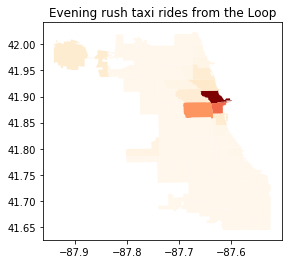

In [31]:
chi_map['From_Loop'] = from_Loop

chi_map.plot(column='From_Loop', cmap='OrRd')
plt.title('Evening rush taxi rides from the Loop')
plt.savefig('Figs/evening_taxi_from_Loop_full.png')
plt.show()

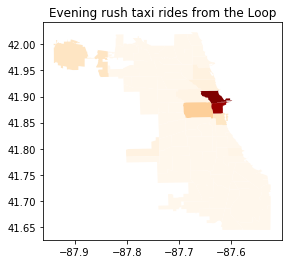

In [33]:
chi_map['To_Loop'] = to_Loop

chi_map.plot(column='To_Loop', cmap='OrRd')
plt.title('Evening rush taxi rides from the Loop')
plt.savefig('Figs/evening_taxi_to_Loop_full.png')
plt.show()

## Fare

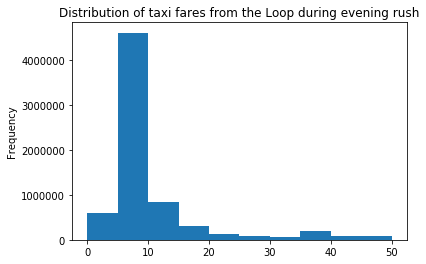

In [34]:
df['Fare'][df.Fare <= 50].plot.hist() #There are some outliers with very high fares

plt.title('Distribution of taxi fares from the Loop during evening rush')
plt.savefig('Figs/taxi_fare_hist_full.png')
plt.show()

## Prediction
It would be good to know, both for road users and the city, when congestion should be expected. First, make a very simple prediction model just based on simple date information. The taxi ride volume is declining because of Uber/Lyft over time, and traffic patterns change by day of the week. I'll also include month as an additional (categorical) feature.

Later, add things like holiday and weather information.

In [47]:
#Make date column to group data by
df['date'] = df['Trip Start Timestamp'].apply(lambda x: x.date())

In [232]:
#Trips by date
df_counts = df['date'].value_counts().reset_index()

In [233]:
#the labels are not quite right
df_counts.head()

,index,date
0,2015-03-06,7173
1,2014-12-18,7135
2,2014-12-17,7038
3,2015-03-05,7015
4,2015-02-19,6993


In [240]:
df_by_date = pd.DataFrame()
df_by_date['date'] = df_counts['index']
df_by_date['trips'] = df_counts['date']

In [241]:
#Make features
df_by_date['day_from_start'] = df_by_date['date'].apply(lambda x: (x-date(2013,1,1)).days)
df_by_date['dayofweek'] = df_by_date['date'].apply(lambda x: x.weekday())
df_by_date['month'] = df_by_date['date'].apply(lambda x: x.month)

In [242]:
df_by_date

,date,trips,day_from_start,dayofweek,month
0,2015-03-06,7173,794,4,3
1,2014-12-18,7135,716,3,12
2,2014-12-17,7038,715,2,12
3,2015-03-05,7015,793,3,3
4,2015-02-19,6993,779,3,2
5,2014-05-15,6947,499,3,5
6,2014-12-19,6902,717,4,12
7,2014-08-01,6842,577,4,8
8,2014-04-03,6822,457,3,4
9,2014-12-11,6800,709,3,12


In [245]:
#day_from_start, dayofweek, and month are the features
X = df_by_date.iloc[:,2:].values
y = df_by_date.iloc[:,1].values.reshape((-1,1))

In [247]:
#dayofweek and month are categorical features
enc = preprocessing.OneHotEncoder()

In [280]:
#make one hot encoding for these 2 columns, and concatenate with day_from_start column
enc.fit(X[:,1:])
X_one_hot = np.concatenate((X[:,0].reshape((-1,1)),
                            enc.transform(X[:,1:]).toarray()), axis=1)

In [282]:
regr = linear_model.LinearRegression()
regr.fit(X_one_hot, y)
print(regr.coef_)

[[ -4.92379102e-01   1.48208817e+02   6.82888109e+02   8.17025516e+02
    8.79314400e+02   7.56058662e+02  -1.19208212e+03  -2.09141339e+03
   -6.30777256e+02  -9.82245498e+01   1.86807572e+02   1.23691763e+02
    7.10619503e-01   3.19250327e+01  -2.22557267e+02   1.00214817e+02
   -4.92315594e+01   3.39742354e+02   1.03120140e+02   1.14578333e+02]]


This is a super simple fit. There's a pretty significant downward slope over time, and weekends are of course not busy.

See which days don't fit well.

In [283]:
y_pred = regr.predict(X_one_hot)

In [284]:
df_by_date['prediction'] = y_pred
df_by_date['error'] = df_by_date['prediction'] - df_by_date['trips']

In [304]:
#What proportion of days do I predict correctly to 1000 trips? (OK but not that great)
len(df_by_date[df_by_date['error'] < 1000]) / len(df_by_date)

0.8918111177525403

In [306]:
#Look at the worst predicted days
df_by_date.sort_values('error')

,date,trips,day_from_start,dayofweek,month,prediction,error
148,2015-01-26,5934,755,0,1,3744.395345,-2189.604655
20,2014-11-17,6583,685,0,11,4512.759279,-2070.240721
42,2015-01-30,6375,759,4,1,4350.275674,-2024.724326
0,2015-03-06,7173,794,4,3,5150.627233,-2022.372767
4,2015-02-19,6993,779,3,2,4996.236535,-1996.763465
892,2014-08-03,4300,579,6,8,2322.423936,-1977.576064
1053,2015-07-05,3805,915,6,7,1834.212473,-1970.787527
55,2015-01-23,6263,752,4,1,4353.722328,-1909.277672
1,2014-12-18,7135,716,3,12,5240.059302,-1894.940698
753,2015-07-04,4621,914,5,7,2734.036122,-1886.963878


Worst overpredictions are considerably worse (by ~3000 trips and even greater) than the worst underpredictions (~2000 trips), and they are almost all holidays (Christmas, New Year's Day, Thanksgiving, etc.). The next thing to include in this model is holidays.

## Data cleaning?

In [2]:
#Omit 'Taxi ID' for now, as it uses a lot of memory.
columns = ['Trip Start Timestamp', 'Trip End Timestamp',
           'Pickup Community Area', 'Dropoff Community Area', 'Fare']
#Use time parser
time_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')

df_list = []

for chunk in pd.read_csv('Data/Taxi_Trips.csv',
                           iterator=True, chunksize=1000000):
    df = chunk[chunk['Pickup Community Area'] == 32.][columns] #select trips leaving the Loop
    df['hour'] = df['Trip Start Timestamp'].apply(lambda x: time_parser(x).hour) #create hour column
    df_list.append(df[(df.hour >= 16) & (df.hour <= 18)]) #only append evening rush hour trips
    
    #print the number of DataFrames appended so far, and length of the last one appended
    print(len(df_list), len(df_list[-1]))

1 50541
2 47066


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3 7433


KeyboardInterrupt: 

There's something weird happening here. What's causing some chunks to have almost no matches? 3rd chunk is the first one with a problem. Look at it.

In [4]:
#pick out the 3rd chunk
count = 0
for chunk in pd.read_csv('Data/Taxi_Trips.csv',
                        iterator=True, chunksize=1000000,
                        low_memory=False):
    if count == 3:
        df_test = chunk
        break

    count += 1

It appears that many rows at certain spots in data have NaN as the community area (and other) values.

In [5]:
df_test.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
3000000,f96e03e5c87dc42c85bc63209355543fa9196629,05a41dad4407c4cb2f03db2b1bb91a6624068a1fa381a0...,06/18/2015 09:30:00 AM,06/18/2015 10:00:00 AM,1560.0,11.4,NaN,NaN,NaN,NaN,...,$35.82,Credit Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000001,f96e04c385d9421d6c75ddd034b88fb4ce41b45e,4dcbf823cafcd373eaa71d2041d5daca63ab8ef17164ef...,06/26/2016 06:00:00 PM,06/26/2016 06:00:00 PM,0.0,0.0,NaN,NaN,NaN,NaN,...,$13.40,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000002,f96e05373b4b30e4528a77b3585934214367fbfb,52adf033bb533b6bd92cb6b683766bbfe9f239be7cc40c...,10/04/2013 04:45:00 PM,10/04/2013 04:45:00 PM,0.0,0.0,NaN,NaN,NaN,NaN,...,$29.81,Credit Card,Taxi Affiliation Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000003,f96e0b2ec695ea21787a403ba46ab9a29b2799a7,5505f562eceb4f7a23e813fa614c5dc63ce7de5f35123e...,12/05/2014 08:00:00 PM,12/06/2014 12:00:00 AM,14760.0,1.1,NaN,NaN,NaN,NaN,...,$8.81,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000004,f96e065744bb74d36c1e2f00db096936610ccbc0,d41ab2be597b82c3e6b0b0ecccf98883a84db0d9aed4f6...,12/19/2014 02:00:00 PM,12/19/2014 02:15:00 PM,420.0,0.8,NaN,NaN,NaN,NaN,...,$6.05,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There may or may not be anything I can do here. There's quite a bit of data that I can use.

One lingering question, though, is why are some parts of the data like this, but not others? If there's a correlation to some feature of the data, that's going to mess with any conclusions you might draw.